In [676]:
%load_ext autoreload
%autoreload 1
%aimport Utils
%aimport MatrixLinkGenerator
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
# np.set_printoptions(linewidth=np.inf)
from obspy import UTCDateTime as dt
import json
import matplotlib.pyplot as plt
from Utils import trainingResults, trainingResults2, predsMap
# plt.rcParams['figure.figsize'] = [50, 200]
plt.rcParams['figure.figsize'] = [16, 12]
params = json.loads('''{
    "extents": {
        "ak": {
            "latMin": 55.0,
            "latMax": 74.0,
            "lonMin": -163.0,
            "lonMax": -130.0
        },
        "s1": {
            "latMin": 22.0,
            "latMax": 40.0,
            "lonMin": 33.0,
            "lonMax": 62.0
        },
        "global": {
            "latMin": -90.0,
            "latMax": 90.0,
            "lonMin": -180.0,
            "lonMax": 180.0
        }
    },
    "location": "global",
    "maxDepth": 50.0,
    "maxStationElevation": 1.0,
    "trainingGeneratorSourceFile": "./Inputs/IDC 10-20.gz",
    "trainingEventsFile": "./Training/Event Files/IDC 10-20 ECEF Times.npz",
    "validationGeneratorSourceFile": "./Inputs/IDC 10-20.gz",
    "validationEventsFile": "./Training/Event Files/IDC 10-20 ECEF Times.npz",
    "arrivalProbsFile": "./Training/RSTT Model/S1 Dropouts.npy",
    "stationFile": "./Archive/Stations/S1 Station List.txt",
    "oneHot": "True",
    "arrivalProbMods": {
        "Pg": 5.0,
        "Pn": 3.0,
        "Sg": 5.0,
        "Sn": 25.0
    },
    "eventsPerExample": {
        "min": 6,
        "max": 20
    },
    "stationsPerBatch": {
        "min": 45,
        "max": 55
    },
    "timeShifts": {
        "min": -0.50,
        "max": 0.50
    },
    "batchSize": 100,
    "samplesPerEpoch": 1000000,
    "validationSamplesPerEpoch": 250000,
    "epochs": 1000,
    "model": "./Training/Models/IDC/E021 L0.0003 AL0.0000 LL69.2918 TL0.0000 AA1.0000 AP1.0000 AR1.0000.h5",
    "evalInFile": "./Inputs/S1 00.gz",
    "evalOutFile": "./Training/Evaluation.gz",
    "prlEvalOutFile": "./Training/PRL Evaluation.gz",
    "maxArrivals": 250,
    "minArrivals": 5,
    "maxNoise": 0.20,
    "clusterStrength": 2.0,
    "timeNormalize": 3600,
    "associationWindow": 3600,
    "evalWindow": 10.0,
    "phases": {
        "P": 0,
        "LR": 1,
        "Pn": 2,
        "T": 3,
        "tx": 4,
        "N": 5,
        "Sx": 6,
        "Pg": 7,
        "Lg": 8,
        "Sn": 9,
        "S": 10
    },
    "modelArch": {
        "dense": [32, 32, 32, 64, 64],
        "transformers": [128, 128],
        "heads": 4,
        "dense2": [128, 128, 128],
        "grus": [128, 128]
    }
}''')
tf.config.list_physical_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [677]:
import random
import rstt
from copy import deepcopy
from collections import deque
modelPath = "./Training/RSTT Model/pdu202009Du.geotess"
def generateEventFile(params, trainingSet = False):
    if trainingSet:
        eventsFile = params['trainingEventsFile']
        generatorFile = params['trainingGeneratorSourceFile']
    else:
        eventsFile = params['validationEventsFile']
        generatorFile = params['validationGeneratorSourceFile']
    try:
        evFile = np.load(eventsFile, allow_pickle=True)
        events = evFile['events'].flatten()[0]
        eventsList = evFile['eventsList']
        print("Training events loaded.") if trainingSet else print("Validation events loaded.")
    except:
        print("Events not loaded. Building from scratch.")
        extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
        latRange = abs(extents[1] - extents[0])
        lonRange = abs(extents[3] - extents[2])
        timeNormalize = params['timeNormalize']
        phases = params['phases']
        events = {}
        eventsList = []
        inputArrivals = pd.read_pickle(generatorFile).sort_values(by="TIME")
        groupedEvents = (inputArrivals.groupby('EVID').filter(lambda x: len(x) >= params['minArrivals'])).groupby('EVID')
        count = 0
        for eid, arrivals in groupedEvents:
            count += 1
            print("\rBuilding event list: " + str(count) + ' / ' + str(len(groupedEvents)), end='')
            eventArrivals = []
            first = dt(arrivals.TIME.min())
            evtime = -(first - dt(arrivals.EV_TIME.min())) / timeNormalize
            for i, arrival in arrivals.iterrows():
                sx,sy,sz = ll2ecef(arrival.ST_LAT, arrival.ST_LON)
                ex,ey,ez = ll2ecef(arrival.EV_LAT, arrival.EV_LON)
                thisArrival = [sx,                                        # normalized station x
                               sy,                                        # normalized station y
                               sz,                                        # normalized station z
                               ((dt(arrival.TIME)-first)/timeNormalize),  # normalized arrival time
                               phases[arrival.PHASE],                     # phase
                               1.,                                        # valid arrival flag
                               5.0 / timeNormalize,                       # arrival uncertainty
                               0.9,                                       # retention rate when dropping some arrivals
                               ex,                                        # normalized event x
                               ey,                                        # normalized event y
                               ez,                                        # normalized event z
                               evtime]                                    # normalized event time (relative to first arrival)
                eventArrivals.append(thisArrival)
            events[eid] = np.array(eventArrivals)
            eventsList.append(np.array([eid,arrivals.TIME.min()]))
        eventsList = np.array(eventsList)
        eventsList = eventsList[np.argsort(eventsList[:,1])]
        np.savez_compressed(eventsFile, events=events, eventsList=eventsList)
        print()
    return events, eventsList
def buildAssociationMatrix(evids):
    L = np.zeros((len(evids), len(evids))) + 99
    sparse_evids = evids[evids>=0]
    l = np.ones((len(sparse_evids), len(sparse_evids))) * sparse_evids.reshape((-1, 1))
    L[:len(sparse_evids), :len(sparse_evids)] = (l == l.T) * 1
    return L

def synthesizeEventsFromEventFile(params, events, eventList, trainingSet = False):
    maxArrivals = params['maxArrivals']
    minTimeShift = params['timeShifts']['min']
    maxTimeShift = params['timeShifts']['max']
    minEvents = params['eventsPerExample']['min']
    maxEvents = params['eventsPerExample']['max']+1 # because using in np.random.randint
    dropFactor = 0.5
    batchSize = params['batchSize']
    start = eventList[0][1]
    end = eventList[-1][1]

    while True:
        X = []
        Y = []
        example = 0
        time = start
        while example < batchSize:
            #Setup - choose random events, with the first being the primary event
#             numEvents = np.random.randint(minEvents, maxEvents)
#             chosenEvents = random.sample(eventList, numEvents)

            chosenEvents = np.where((trainingEventList[:,1] >= time) & (trainingEventList[:,1] <= time+timeNormalize))[0]
            if time > end:
                time = start
            else:
                time += timeNormalize
            numEvents = len(chosenEvents)
            if numEvents == 0:
                continue

            timeShifts = np.random.uniform(minTimeShift, maxTimeShift, size=numEvents-1)
            for i in range(0, len(chosenEvents)):
                thisEvent = events[eventList[chosenEvents[i]][0]]
                #Randomly drop some picks from the event
                if trainingSet:
                    drops = thisEvent[:,7]
                    drops = drops + dropFactor*(1-drops) if dropFactor > 0 else drops*(1+dropFactor)
                    drops = np.random.binomial(1,drops)
                    idx = np.where(drops==1)[0]
                    thisEvent = thisEvent[idx,:]
                if i == 0:
                    sequence = thisEvent
                    sequence[:,5] = i
                else:
                    #Add the picks from this event
                    currentLength = len(sequence)
                    sequence = np.append(sequence, thisEvent, axis=0)
                    #Shift the starting time of this event
                    sequence[currentLength:currentLength+len(thisEvent),[3,11]] += timeShifts[i-1]
                    sequence[currentLength:currentLength+len(thisEvent),5] = i

            #Add random arrival time errors, except for the first pick of the primary event
            if trainingSet:
                timeShifts = np.random.uniform(-sequence[1:,6]*0.5, sequence[1:,6]*0.5)
                sequence[1:,3] += timeShifts

            #Sort by arrival time, drop picks with negative arrival times
            idx = np.argsort(sequence[:,3])
            remove = len(np.where((sequence[:,3] < 0))[0])
            idx = idx[remove:]
            sequence = sequence[idx,:]
            if len(sequence) == 0: #We lost all the valid arrivals, so scrap this training example
                continue

            #Make labels array
            labels = buildAssociationMatrix(sequence[:,5])

            #Reset primary event times
            ones = np.where(labels[0]==1)
#             if len(ones[0]) == 0: #We lost all the valid arrivals, so scrap this training example
#                 continue
            sequence[ones,3] -= sequence[ones,3][0][0]
            idx = np.argsort(sequence[:,3])

            #Truncate picks over maximum allowed
            idx = idx[:maxArrivals]
            sequence = sequence[idx,:]
            labels = labels[idx,:maxArrivals]

            sequence[:,5] = 1.
            #Pad the end if not enough picks were selected
            padding = maxArrivals - len(sequence)
            if padding > 0:
                labels = np.pad(labels, (0, maxArrivals-len(labels)), constant_values=99.)
                sequence_ = np.full((maxArrivals, 12), 0.)
#                 sequence_[sequence.shape[0]:, [8,9,10]] = 99.
                sequence_[:sequence.shape[0], :] = sequence
                sequence = sequence_
            X.append(sequence)
            Y.append(labels)
            example += 1
            
        #Yield these training examples
        X = np.array(X)
        Y = {"association": np.array(Y), "location": X[:,:,[8,9,10]], "time": X[:,:,11]}
        X = {"phase": X[:,:,4], "numerical_features": X[:,:,[0,1,2,3,5]]}
        yield X, Y

In [678]:
maxArrivals = params['maxArrivals']
from tensorflow.keras import backend as K
from geographiclib.geodesic import Geodesic
from tensorflow.keras.losses import binary_crossentropy as BCE
from tensorflow.keras.metrics import binary_accuracy

K.set_floatx('float64')
maxArrivals = params['maxArrivals']
matrixSize = maxArrivals**2
extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
latRange = abs(extents[1] - extents[0])
lonRange = abs(extents[3] - extents[2])
timeNormalize = params['timeNormalize']
zero = np.float64(0)
one = np.float64(1)
r = np.float64(12756.2)
nn = np.float64(99)

import pymap3d as pm
xym = 6378137.0
xym2 = 2*xym
zm = 6356752.3142451802
zm2 = 2*zm
def ll2ecef(lat,lon):
    x,y,z = pm.geodetic2ecef(lat, lon, 0)
    x = (x+xym)/xym2
    y = (y+xym)/xym2
    z = (z+zm)/zm2
    return x,y,z
def ecef2ll(x,y,z):
    x = x*xym2 - xym
    y = y*xym2 - xym
    z = z*zm2 - zm
    x,y,z = pm.ecef2geodetic(x,y,z)
    return x,y

def nzHaversine(y_true, y_pred):
#     y_pred = y_pred * tf.cast(y_true != nn, tf.float64)
#     y_true = y_true * tf.cast(y_true != nn, tf.float64)
    observation = tf.stack([y_true[:,:,0]*latRange + extents[0], y_true[:,:,1]*lonRange + extents[2]],axis=2)*0.017453292519943295
    prediction = tf.stack([y_pred[:,:,0]*latRange + extents[0], y_pred[:,:,1]*lonRange + extents[2]],axis=2)*0.017453292519943295
    used = tf.reduce_sum(tf.cast(tf.greater(tf.reduce_sum(y_true, axis=2),0), dtype=tf.float64), axis=1)
    used = tf.where(tf.equal(used, zero), one, used)
    dlat_dlon = (observation - prediction) / 2
    a = tf.sin(dlat_dlon[:,:,0])**2 + tf.cos(observation[:,:,0]) * tf.cos(prediction[:,:,0]) * tf.sin(dlat_dlon[:,:,1])**2
    c = tf.asin(tf.sqrt(a))*r
    return tf.reduce_sum((tf.reduce_sum(c, axis=1))/used) / tf.dtypes.cast(tf.shape(observation)[0], dtype=tf.float64)

def nzTime(y_true, y_pred):
    y_pred = y_pred * tf.cast(y_true != nn, tf.float64)
    y_true = y_true * tf.cast(y_true != nn, tf.float64)
    used = maxArrivals - tf.reduce_sum(tf.cast(tf.equal(y_true, zero), dtype=tf.float64), axis=1)
    used = tf.where(tf.equal(used, zero), one, used)
    diffs = tf.math.abs(tf.squeeze(y_pred)-y_true)*timeNormalize
    diffs = (tf.squeeze(y_pred)-y_true)*timeNormalize
    diffs = tf.reduce_sum(tf.reduce_sum(diffs, axis=1)/used)
    return diffs/tf.dtypes.cast(tf.shape(y_true)[0], dtype= tf.float64)

def nzMSE(y_true, y_pred):
    y_pred = y_pred * tf.cast(y_true != nn, tf.float64)
    y_true = y_true * tf.cast(y_true != nn, tf.float64)
    used = maxArrivals - tf.reduce_sum(tf.cast(tf.equal(y_true,0), dtype=tf.float64), axis=1)
    used = tf.where(tf.equal(used, zero), one, used)
    return K.mean(tf.reduce_sum(K.square(tf.squeeze(y_pred)-y_true),axis=1)/used)

def nzBCE(y_true, y_pred):
    y_pred = y_pred * tf.cast(y_true != nn, tf.float64)
    y_true = y_true * tf.cast(y_true != nn, tf.float64)
    used = maxArrivals - tf.reduce_sum(tf.cast(tf.equal(y_true,0), dtype=tf.float64), axis=1)
    used = tf.where(tf.equal(used, zero), one, used)
    return K.mean(BCE(y_true, y_pred)/used)

def nzAccuracy(y_true, y_pred):
    used = matrixSize/(tf.reduce_sum(tf.cast(tf.greater(tf.reduce_sum(y_true, axis=1), zero), dtype=tf.float64), axis=1)**2)
    used = tf.where(tf.equal(used, zero), one, used)
    acc = tf.reduce_sum(tf.cast(y_true==tf.round(y_pred), dtype=tf.float64),axis=(1,2))/matrixSize
    return K.mean(acc*used - used + 1)

def nzRecall(y_true, y_pred):
    y_pred = y_pred * tf.cast(y_true != nn, tf.float64)
    y_true = y_true * tf.cast(y_true != nn, tf.float64)
#     y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (all_positives + K.epsilon())

def nzPrecision(y_true, y_pred):
    y_pred = y_pred * tf.cast(y_true != nn, tf.float64)
    y_true = y_true * tf.cast(y_true != nn, tf.float64)
#     y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

In [679]:
#MatrixLinkTrainer
import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Reshape, concatenate, Dense, Bidirectional, GRU, MultiHeadAttention, LayerNormalization, Lambda
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.backend import clip
import logging
import json

@tf.autograph.experimental.do_not_convert
def MatrixLink(params):
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    def buildModel(modelArch):
        outputs = []
        inputs = []
        numericalInputs = Input(shape=(None,5), name='numerical_features')
        outputs.append(numericalInputs)
        inputs.append(numericalInputs)
        categoricalInputs = Input(shape=(None,1), name='phase')
        embed = Embedding(11, 4, trainable=True, embeddings_initializer=RandomNormal())(categoricalInputs)
        embed = Reshape(target_shape=(-1, 4))(embed)
        outputs.append(embed)
        inputs.append(categoricalInputs)
        outputs = concatenate(outputs)

        def TransformerBlock(inputs, embed_dim, ff_dim, num_heads=2, rate=0.1, eps=1e-6):
            attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
#             attn_output = Dropout(rate)(attn_output)
            out1 = LayerNormalization(epsilon=eps)(inputs + attn_output)
            ffn_output = Dense(ff_dim, activation="relu")(out1)
            ffn_output = Dense(embed_dim)(ffn_output)
#             ffn_output = Dropout(rate)(ffn_output)
            return LayerNormalization(epsilon=eps)(out1 + ffn_output) 

        for d1Units in modelArch['dense']:
            outputs = Dense(units=d1Units, activation=tf.nn.relu)(outputs)
        transformerOutputs = outputs
        gruOutputs = outputs

        for tUnits in modelArch['transformers']:
            transformerOutputs = TransformerBlock(transformerOutputs, d1Units, tUnits, modelArch['heads'])
        for gUnits in modelArch['grus']:
            gruOutputs = Bidirectional(GRU(gUnits, return_sequences=True))(gruOutputs)

        outputs = concatenate([transformerOutputs, gruOutputs], axis=2)
        for tUnits in modelArch['transformers']:
            outputs = TransformerBlock(outputs, d1Units+gUnits*2, tUnits, modelArch['heads'])

        association = Dense(units=params['maxArrivals'], activation=tf.nn.sigmoid, name='association')(outputs)
        location = Dense(units=3)(outputs)
        location = Lambda(lambda x: clip(x, 0, 1), name='location')(location)
        time = Dense(units=1, name='time')(outputs)
        
        model = Model(inputs=inputs, outputs=[association, location, time])
        losses = { 'association': nzBCE, 'location': nzMSE, 'time': nzMSE }
        weights = { 'association': 1.0, 'location': 1.0, 'time': 0.1 }
        metrics = { 'association': [nzAccuracy, nzPrecision, nzRecall] }
        model.compile(optimizer=Adam(clipnorm=0.00001), loss=losses, loss_weights=weights, metrics=metrics)
        return model

    model = buildModel(params['modelArch'])
    try:
        model.load_weights(params['model'])
        print("Loaded previous weights.")
    except Exception as e:
        print(e)
        print("No previous weights loaded.")
    print(model.summary())
    return model

class saveCb(Callback):
    def on_train_begin(self, logs=None):
        self.best = 100000000.
    def on_epoch_end(self, epoch, logs=None):
        if logs['loss'] < self.best:
            self.best = logs['loss']
            print('Saving best model with loss', self.best)
            modelName = 'E%03d L%.4f AL%.4f LL%.4f TL%.4f AA%.4f AP%.4f AR%.4f.h5' %\
                (epoch, logs['loss'], logs['association_loss'], logs['location_loss'], logs['time_loss'], logs['association_nzAccuracy'], logs['association_nzPrecision'], logs['association_nzRecall'])
            model.save("./Training/Models/IDC/"+modelName)

In [ ]:
# tf.config.threading.set_intra_op_parallelism_threads(2)
# tf.config.threading.set_inter_op_parallelism_threads(2)

trainingEvents, trainingEventList = generateEventFile(params, trainingSet=True)
for event in trainingEventList[:,0]:
    trainingEvents[event] = trainingEvents[event][np.where(trainingEvents[event][:,3] <= .6)[0]]
# validationEvents, validationEventList = generateEventFile(params)

generator = synthesizeEventsFromEventFile(params, trainingEvents, trainingEventList, trainingSet=True)
# generator = synthesizeEvents(params)
# vgen = synthesizeEventsFromEventFile(params, validationEvents, validationEventList)
# vgen = synthesizeEvents(params)

model = MatrixLink(params)
history = model.fit(generator,
#                  validation_data=vgen,
                 steps_per_epoch= params['samplesPerEpoch']/params['batchSize'],
#                  validation_steps = params['validationSamplesPerEpoch']/params['batchSize'],
                 epochs=params['epochs'],
                 callbacks=[saveCb(), EarlyStopping(monitor='loss', patience=50), CSVLogger('./Training/Models/IDC/logs2.csv', append = True)],
                 verbose=1)
# trainingResults(np.genfromtxt('./Training/Models/IDC/logs.csv', delimiter=',', names=True))

Reading input file... 16451 arrivals found
Creating permutations... 742 / 743
Making initial predictions... clustering and building events...
Promoting event 275
Matching event 275 / 275        
Evaluating event 275 / 275                
-----------------------------
IoU evaluation for events with at least 5 arrivals for model ./Training/Models/IDC/E021 L0.0003 AL0.0000 LL69.2918 TL0.0000 AA1.0000 AP1.0000 AR1.0000.h5
Parameters - evalInFile: ./Inputs/IDC 10-20.gz	 maxArrivals: 250	 associationWindow: 3600	 clusterStrength: 2.0
Totals/Average IoU: 3207 / 8907 = 0.3600538901987201
Precision: 0.6551583248212461
Recall: 0.31361236064932524
F1: 0.42417829508630384
Fake Arrivals: 0 / 0
Created / Actual Events: 275 / 719
Missed Events: 186
Merged Events: 246
Fake Events: 0
Arbitrary Health Measure: 2.8487236576543675

Location Errors Summary
Mean: 2486.80
STD:  3521.19
Min:     8.87
25%:   382.50
50%:   907.35
75%:  2675.37
Max: 17881.42

Time Errors Summary
Mean: 1558.90
STD:  1027.98
Min: 

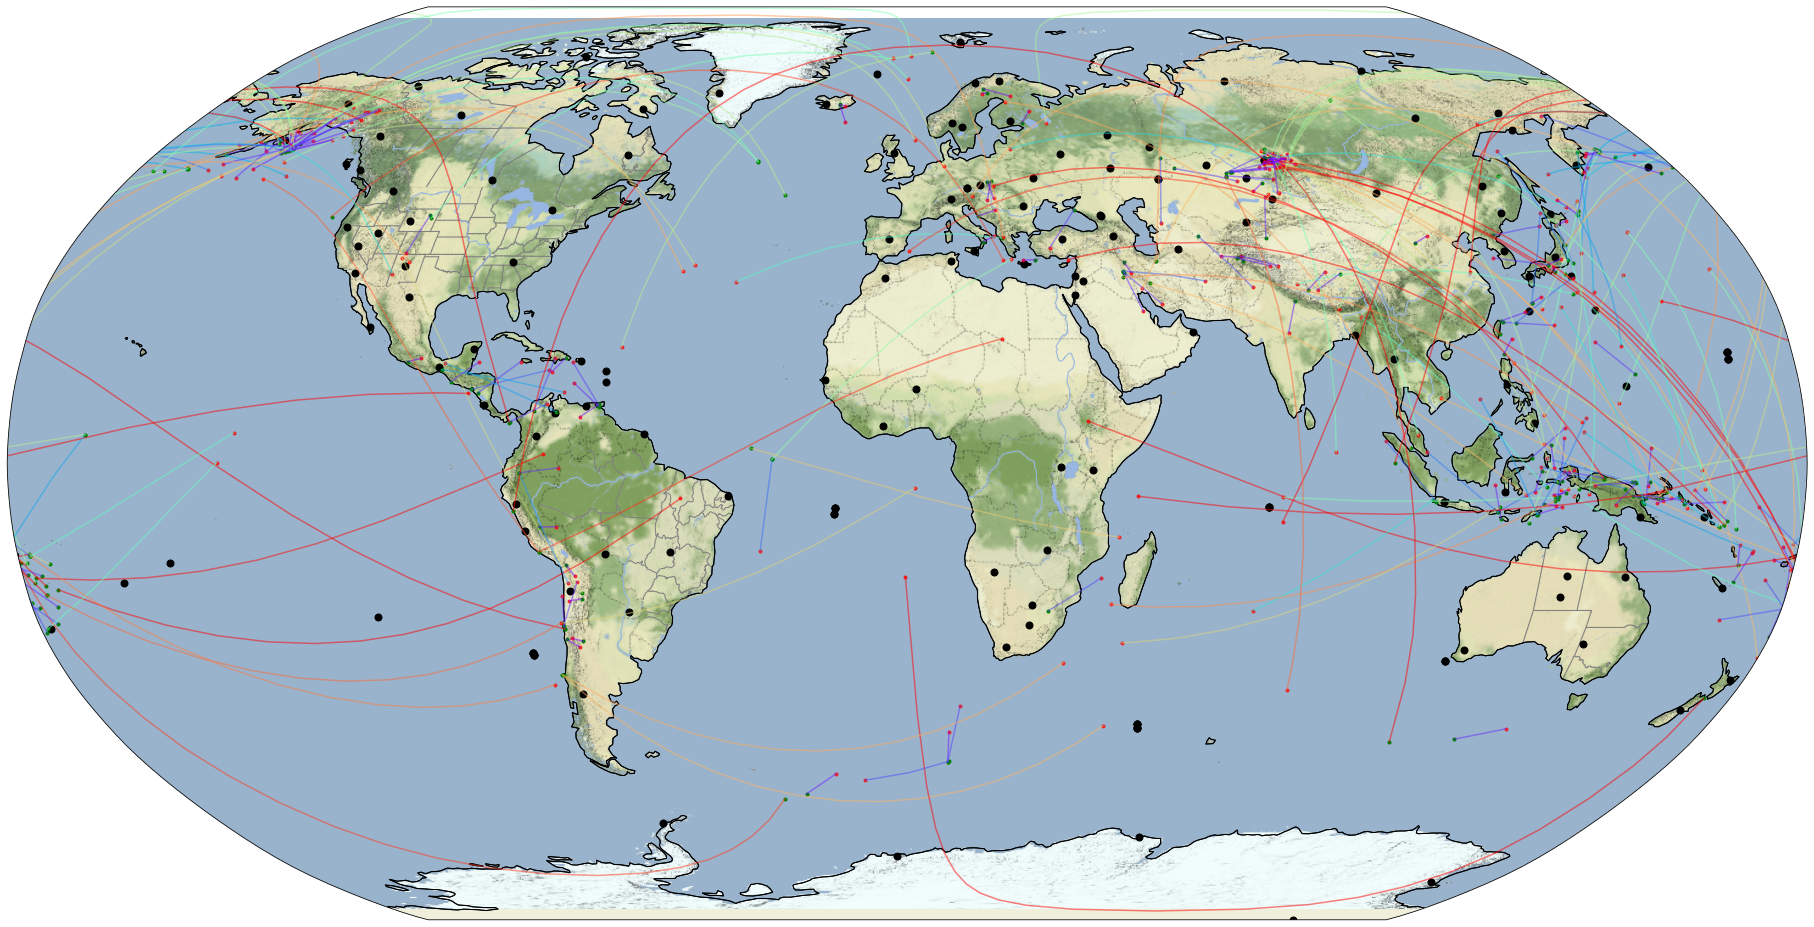

-----------------------------
Consolidated summary for: ./Training/Models/IDC/E021 L0.0003 AL0.0000 LL69.2918 TL0.0000 AA1.0000 AP1.0000 AR1.0000.h5
File	AHM	 Location
20     2.85  2486.80


In [681]:
#MatrixLink
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from collections import deque
from math import ceil
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras.models import load_model
from obspy import UTCDateTime
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import squareform
from Utils import nzBCE, nzMSE1, nzMSE2, nzHaversine, nzAccuracy, nzPrecision, nzRecall, nzTime, evaluate
overlapLosses = []
# Build permutation lists and matrices to predict on
def permute(X):
    outerWindow = params['associationWindow']
    minArrivals = params['minArrivals']
    maxArrivals = params['maxArrivals']
    edgeWindow = outerWindow/5
    numWindows = ceil((X[:,3].max() + edgeWindow*2) / edgeWindow)
    start = -edgeWindow

    innerWindows = deque()
    X_perm = deque()
    for window in range(numWindows):
        print('\rCreating permutations... ' + str(window) + ' / ' + str(numWindows), end='')
        end = start+outerWindow
        windowArrivals = np.where((X[:,3] >= start) & (X[:,3] < end))[0]
        start += edgeWindow
        if len(windowArrivals) >= minArrivals:
            X_perm.append(windowArrivals[:maxArrivals])
            innerWindows.append(start)
    X_test = np.zeros((len(X_perm),maxArrivals,6))
    for i in range(len(X_perm)):
        X_test[i,:len(X_perm[i])] = X[X_perm[i]]
        X_test[i,:len(X_perm[i]),3] -= X_test[i,0,3]
    X_test[:,:,3] /= params['timeNormalize']
    return X_perm, X_test, innerWindows

def buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows, clusterStrength, evid=1):
    # Get clusters for predicted matrix at index i
    def cluster(i):
        valids = np.where(X_test[i][:,-1])[0]
        validPreds = Y_pred[0][i][valids,:len(valids)]
        L = 1-((validPreds.T + validPreds)/2)
        np.fill_diagonal(L,0)
        return fcluster(ward(squareform(L)), clusterStrength, criterion='distance')

    innerWindow = params['associationWindow'] * (3/5)
    minArrivals = params['minArrivals']
    catalogue = pd.DataFrame(columns=labels.columns)
#     events = deque()
    created = 1
    for window in range(len(X_perm)):
        clusters = cluster(window)
        for c in np.unique(clusters):
            pseudoEventIdx = np.where(clusters == c)[0]
            pseudoEvent = X_perm[window][pseudoEventIdx]
            if len(pseudoEvent) >= minArrivals:
                event = X[pseudoEvent]
#                 event = event[event[:,3] <= event[0,3]+innerWindow]
                # check for containment within inner window
                contained = (event[0,3] >= innerWindows[window]) & (event[-1,3] <= (innerWindows[window]+innerWindow))
                if contained:
                    candidate = labels.iloc[pseudoEvent].copy()
                    try:
                        candidate['ETIME'] = candidate.TIME.min() + np.median(Y_pred[2][window][pseudoEventIdx][:]*params['timeNormalize'])
                    except:
                        candidate['ETIME'] = -1
                    candidate['PLAT'] = Y_pred[1][window][pseudoEventIdx][:,0]*latRange+extents[0]
                    candidate['PLON'] = Y_pred[1][window][pseudoEventIdx][:,1]*lonRange+extents[2]
                    candidate['LAT'] = np.median(candidate.PLAT)
                    candidate['LON'] = np.median(candidate.PLON)
                    # check for existence in catalogue
                    overlap = candidate.ARID.isin(catalogue.ARID).sum()
                    if overlap == 0:
                        print("\rPromoting event " + str(created), end='')
#                         events.append(pseudoEvent)
                        candidate.EVID = evid
                        catalogue = catalogue.append(candidate)
                        evid += 1
                        created += 1
                    else:
                        overlapLosses.extend(candidate.ARID.values)
#                     elif len(pseudoEvent) > overlap:
#                         catalogue.drop(catalogue[catalogue.ARID.isin(candidate.ARID)].index, inplace=True)
#                         candidate.EVID = evid
#                         catalogue = catalogue.append(candidate)
#                         evid += 1
    catalogue = catalogue.groupby('EVID').filter(lambda x: len(x) >= minArrivals)
    print()
    return catalogue

def matrixLink(X, labels, denoise=False):
    print("Creating permutations... ", end='')
    X_perm, X_test, innerWindows = permute(X)
    print("\nMaking initial predictions... ", end='')
    Y_pred = model.predict({"phase": X_test[:,:,4], "numerical_features": X_test[:,:,[0,1,2,3,5]]})
    print("clustering and building events...")
    catalogue = buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows, params['clusterStrength'])
    return catalogue

def processInput(inputs):
    print("Reading input file... ", end='')
    X = []
    labels = []
    for i, r in inputs.iterrows(): # I can do this better
        phase = phases[r.PHASE]
        time = UTCDateTime(r.TIME)
#         lat = abs((r.ST_LAT - extents[0]) / latRange)
#         lon = abs((r.ST_LON - extents[2]) / lonRange)
        x,y,z = ll2ecef(r.ST_LAT, r.ST_LON)
        otime = time - UTCDateTime(0)
        try:
            arrival = [x, y, z, otime, phase, 1]
            X.append(arrival)
            labels.append(r)
        except Exception as e:
            print(e)
    X = np.array(X)
    idx = np.argsort(X[:,3])
    X = X[idx,:]
    X[:,3] -= X[0,3]
    labels = pd.DataFrame([labels[i] for i in idx])
    print("%d arrivals found" % len(labels))
    return X, labels

if __name__ == "__main__":
    pd.options.display.float_format = "{:.2f}".format
#     with open("Parameters.json", "r") as f:
#         params = json.load(f)
    phases = params['phases']
    extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzMSE':nzMSE2, 'nzMSE1':nzMSE1, 'nzMSE2':nzMSE2, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall, 'nzAccuracy':nzAccuracy, 'nzTime':nzTime}, compile=True)

    inFiles = ['./Inputs/IDC Test.gz']
    inFiles = ['./Inputs/IDC 10-20.gz']
    denoise = False
    evals = {file:[] for file in inFiles}
    for i in range(len(inFiles)):
        inputs = pd.read_pickle(inFiles[i]).sort_values(by=['TIME']).reset_index(drop=True)
        params['evalInFile'] = inFiles[i]
        start = inputs[inputs.TIME >= inputs.TIME.quantile(.8)].index[0]
        end = inputs[inputs.TIME >= inputs.TIME.quantile(.802)].index[0]
        inputs = inputs[start:end]

        X, labels = processInput(inputs)
        outputs = matrixLink(X, labels, denoise)
        outputs.to_pickle(params['evalOutFile'])
        evals[inFiles[i]] = evaluate(params, inputs, outputs, verbose=False)

    print("Consolidated summary for:", params['model'])
    print('File\tAHM\t Location')
    for file in evals.keys():
        print(file[-5:-3], "{:8.2f}".format(evals[file][0]), "{:8.2f}".format(evals[file][1]))

In [682]:
len(set(overlapLosses) - set(outputs.ARID.values))


1774

<ipython-input-201-22d113949bae>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat1 = lat1[:, np.newaxis]
<ipython-input-201-22d113949bae>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon1 = lon1[:, np.newaxis]


Reading input file... 9360 arrivals found
Promoting event 110ns... 741 / 742
Matching event 568 / 568        
Evaluating event 568 / 568        
-----------------------------
IoU evaluation for events with at least 5 arrivals for model ./Training/Models/IDC/E146 L0.0119 AL0.0069 LL1116.8705 TL0.0019 AA0.5906 AP0.7471 AR0.3541.h5
Parameters - evalInFile: ./Inputs/IDC 10-20.gz	 maxArrivals: 250	 associationWindow: 3600	 clusterStrength: 2.0
Totals/Average IoU: 6289 / 14222 = 0.44220222190971736
Precision: 0.8333112495031139
Recall: 0.4027021835179612
F1: 0.542997755137282
Fake Arrivals: 0 / 0
Created / Actual Events: 568 / 719
Missed Events: 86
Merged Events: 267
Fake Events: 0
Arbitrary Health Measure: 10.498391493993772

Location Errors Summary
Mean: 1629.94
STD:  3099.09
Min:     4.89
25%:   191.22
50%:   359.17
75%:  1165.95
Max: 17440.26

Time Errors Summary
Mean: 1498.83
STD:  1207.30
Min:     1.36
25%:   989.44
50%:  1317.88
75%:  1621.77
Max: 10487.36


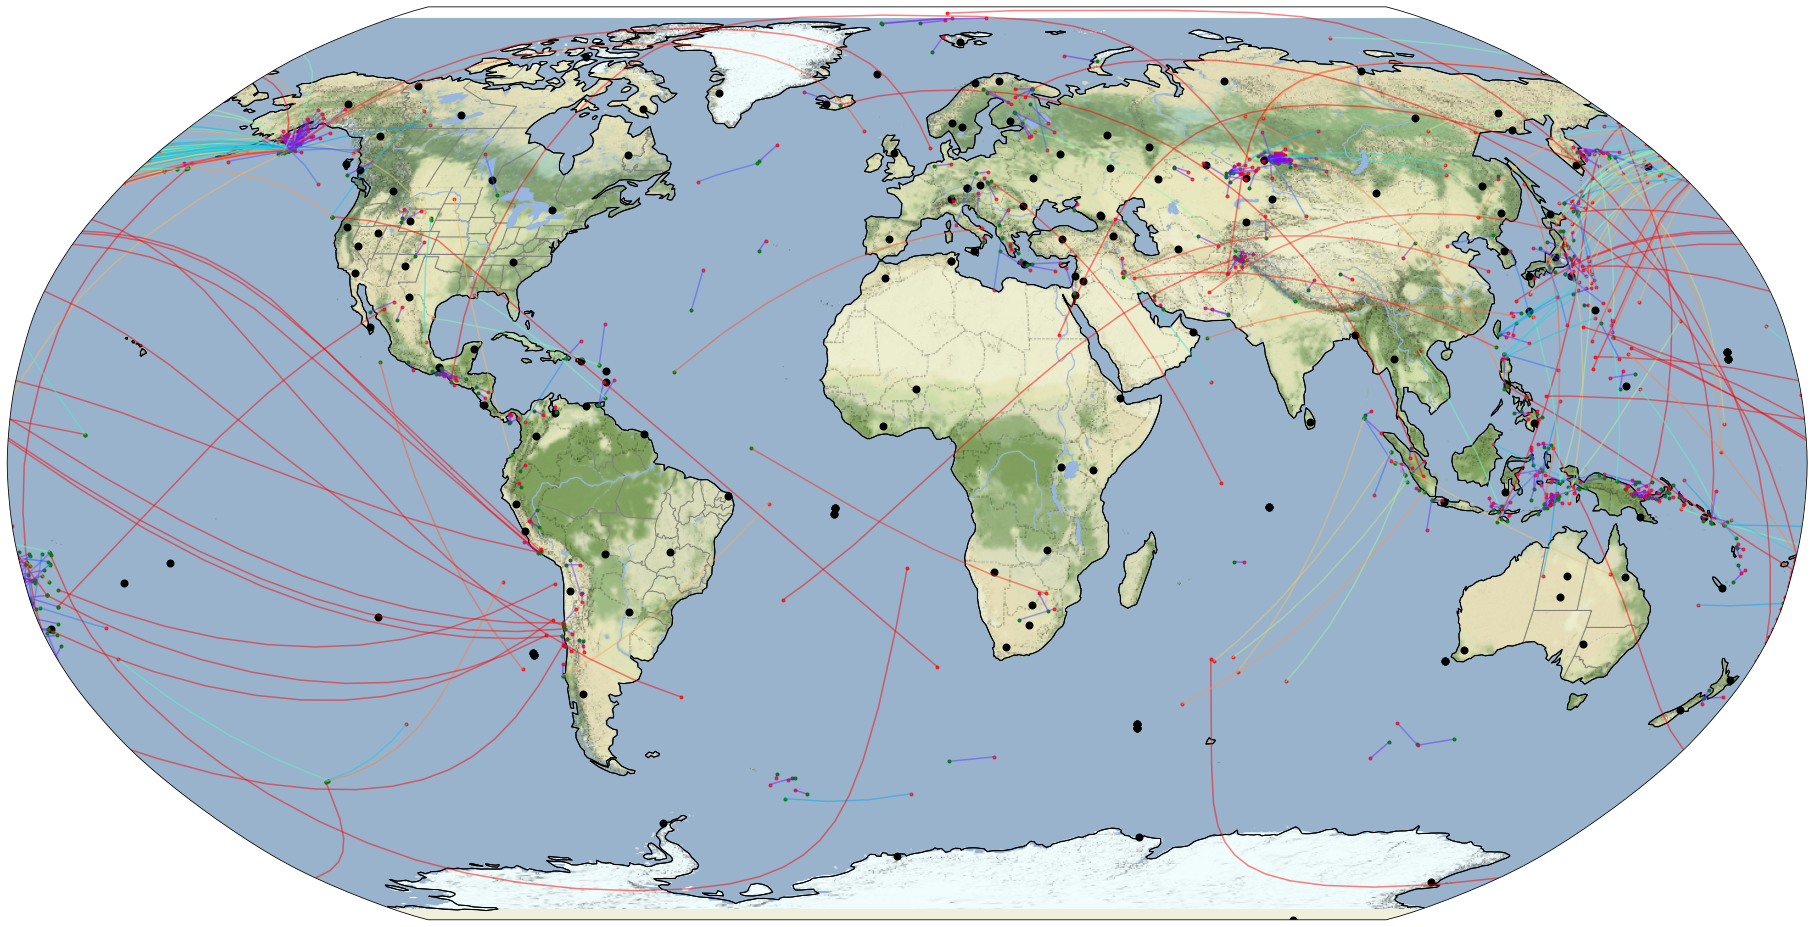

-----------------------------
2540.89297009 2160.0 5032.32047009 4320.0 False
1514.58149004 2160.0 3974.12451005 4320.0 False


In [363]:
# analyzed = pd.read_pickle(params['prlEvalOutFile'])
# analyzed.groupby(['PHASE','RULING']).size() / analyzed.groupby(["PHASE"])['RULING'].size()

# event = outputs[outputs.EVID == 11]
# print(event[['ORID','PLAT','PLON']])
# dists = haversine(event.PLAT, event.PLON, event.LAT.iloc[0], event.LON.iloc[0])
# print(event.iloc[np.where(dists < (dists.mean()+dists.std()))[0]][['ORID','PLAT','PLON']])

# Go through each generated event and find arrivals more than one std away from the event's predicted location
# Remove these arrivals from the events; remove all points still used from the inputs
# Go through each event again and build new windows to predict containing the points in the generated event and those around them from the updated inputs
# Build new events from these predictions; replace events in catalogue

from itertools import chain
lostArrivals = deque()
for evid, event in outputs.groupby('EVID'):
    dists = haversine(event.PLAT, event.PLON, event.LAT.iloc[0], event.LON.iloc[0])
    lostArrivals.append(event.iloc[np.where(dists > (dists.mean()+dists.std()))[0]].ARID.values)
lostArrivals = list(chain.from_iterable(lostArrivals))
outputs2 = outputs.drop(outputs[outputs.ARID.isin(lostArrivals)].index, inplace=False)
inputs2 = inputs[~inputs.index.isin(outputs.index)]

X, labels = processInput(inputs2)
X_perm, X_test, innerWindows = permute(X)
Y_pred = model.predict({"phase": X_test[:,:,4], "numerical_features": X_test[:,:,[0,1,2,3,5]]})
catalogue = buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows, 2.0, outputs2.EVID.max()+1)
evaluate(params, inputs, outputs2.append(catalogue).sort_values(by='TIME'))

catalogue = pd.DataFrame(columns=labels.columns)
minArrivals = 5
created = 0
innerWindow = params['associationWindow'] * (3/5)
window = 3
clusters = cluster(window)
for c in np.unique(clusters):
    pseudoEventIdx = np.where(clusters == c)[0]
    pseudoEvent = X_perm[window][pseudoEventIdx]
    if len(pseudoEvent) >= minArrivals:
        event = X[pseudoEvent]
        # check for containment within inner window
        contained = (event[0,3] >= innerWindows[window]) & (event[-1,3] <= (innerWindows[window]+innerWindow))
        print(event[0,3], innerWindows[window], event[-1,3], innerWindows[window]+innerWindow, contained)
        if contained:
            candidate = labels.iloc[pseudoEvent].copy()
            try:
                candidate['ETIME'] = candidate.TIME.min() + np.median(Y_pred[2][window][pseudoEventIdx][:]*params['timeNormalize'])
            except:
                candidate['ETIME'] = -1
            candidate['PLAT'] = Y_pred[1][window][pseudoEventIdx][:,0]*latRange+extents[0]
            candidate['PLON'] = Y_pred[1][window][pseudoEventIdx][:,1]*lonRange+extents[2]
            candidate['LAT'] = np.median(candidate.PLAT)
            candidate['LON'] = np.median(candidate.PLON)
            # check for existence in catalogue
            overlap = candidate.ARID.isin(catalogue.ARID).sum()
            if overlap == 0:
                print("\rPromoting event " + str(created))
# #                         events.append(pseudoEvent)
#                 candidate.EVID = evid
#                 catalogue = catalogue.append(candidate)
#                 evid += 1
                created += 1

In [647]:
#MatrixLink MSE
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from collections import deque
from math import ceil
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras.models import load_model
from obspy import UTCDateTime
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import squareform
from Utils import nzBCE, nzMSE1, nzMSE2, nzHaversine, nzAccuracy, nzPrecision, nzRecall, nzTime, evaluate

# Build permutation lists and matrices to predict on
def permute(X):
    outerWindow = params['associationWindow']
    minArrivals = params['minArrivals']
    maxArrivals = params['maxArrivals']
    edgeWindow = outerWindow/5
    numWindows = ceil((X[:,3].max() + edgeWindow*2) / edgeWindow)
    start = -edgeWindow

    innerWindows = deque()
    X_perm = deque()
    for window in range(numWindows):
        print('\rCreating permutations... ' + str(window) + ' / ' + str(numWindows), end='')
        end = start+outerWindow
        windowArrivals = np.where((X[:,3] >= start) & (X[:,3] < end))[0]
        start += edgeWindow
        if len(windowArrivals) >= minArrivals:
            X_perm.append(windowArrivals[:maxArrivals])
            innerWindows.append(start)
    X_test = np.zeros((len(X_perm),maxArrivals,6))
    for i in range(len(X_perm)):
        X_test[i,:len(X_perm[i])] = X[X_perm[i]]
        X_test[i,:len(X_perm[i]),3] -= X_test[i,0,3]
    X_test[:,:,3] /= params['timeNormalize']
    return X_perm, X_test, innerWindows

def buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows):
    # Get clusters for predicted matrix at index i
    def cluster(i):
        valids = np.where(X_test[i][:,-1])[0]
        validPreds = Y_pred[0][i][valids,:len(valids)]
        L = 1-((validPreds.T + validPreds)/2)
        np.fill_diagonal(L,0)
        return fcluster(ward(squareform(L)), params['clusterStrength'], criterion='distance')

    innerWindow = params['associationWindow'] * (3/5)
    minArrivals = params['minArrivals']
    catalogue = pd.DataFrame(columns=labels.columns)
#     events = deque()
    evid = 1
    created = 1
    for window in range(len(X_perm)):
        clusters = cluster(window)
        for c in np.unique(clusters):
            pseudoEventIdx = np.where(clusters == c)[0]
            pseudoEvent = X_perm[window][pseudoEventIdx]
            if len(pseudoEvent) >= minArrivals:
                event = X[pseudoEvent]
                # check for containment within inner window
                contained = (event[0,3] >= innerWindows[window]) & (event[-1,3] <= (innerWindows[window]+innerWindow))
                if contained:
                    candidate = labels.iloc[pseudoEvent].copy()
                    try:
                        candidate['ETIME'] = candidate.TIME.min() + np.median(Y_pred[2][window][pseudoEventIdx][:]*params['timeNormalize'])
                    except:
                        candidate['ETIME'] = -1
                    candidate['PLAT'] = Y_pred[1][window][pseudoEventIdx][:,0]
                    candidate['PLON'] = Y_pred[1][window][pseudoEventIdx][:,1]
                    candidate['LAT'] = np.median(candidate.PLAT)
                    candidate['LON'] = np.median(candidate.PLON)
                    # check for existence in catalogue
                    overlap = candidate.ARID.isin(catalogue.ARID).sum()
                    if overlap == 0:
                        print("\rPromoting event " + str(created), end='')
#                         events.append(pseudoEvent)
                        candidate.EVID = evid
                        catalogue = catalogue.append(candidate)
                        evid += 1
                        created += 1
#                     elif len(pseudoEvent) > overlap:
#                         catalogue.drop(catalogue[catalogue.ARID.isin(candidate.ARID)].index, inplace=True)
#                         candidate.EVID = evid
#                         catalogue = catalogue.append(candidate)
#                         evid += 1
    catalogue = catalogue.groupby('EVID').filter(lambda x: len(x) >= minArrivals)
    print()
    return catalogue

def matrixLink(X, labels, denoise=False):
    print("Creating permutations... ", end='')
    X_perm, X_test, innerWindows = permute(X)
    print("\nMaking initial predictions... ", end='')
    Y_pred = model.predict({"phase": X_test[:,:,4], "numerical_features": X_test[:,:,[0,1,2,3,5]]})
    
    for event in range(Y_pred[1].shape[0]):
        for arrival in range(maxArrivals):
            x,y,z = Y_pred[1][event][arrival]
            Y_pred[1][event][arrival,:2] = ecef2ll(x,y,z)
    
    if denoise:
        print("\nEliminating noise and predicting again... ", end='')
        for _ in range(3):
            valids = deque()
            for i in range(len(X_perm)):
                noise = np.where(Y_pred[2][i] > 0.008)[0]
                valids.append(np.delete(X_perm[i], noise[noise < len(X_perm[i])]))
            valids = np.array(list(set(np.concatenate(valids))))
            X = X[valids]
            labels = labels.iloc[valids]
            X_perm, X_test, innerWindows = permute(X)
            Y_pred = model.predict({"phase": X_test[:,:,4], "numerical_features": X_test[:,:,[0,1,2,3,5]]})
    print("clustering and building events...")
    catalogue = buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows)
    return catalogue

def processInput():
    print("Reading input file... ", end='')
    X = []
    labels = []
    for i, r in inputs.iterrows(): # I can do this better
        phase = phases[r.PHASE]
        time = UTCDateTime(r.TIME)
#         lat = abs((r.ST_LAT - extents[0]) / latRange)
#         lon = abs((r.ST_LON - extents[2]) / lonRange)
        x,y,z = ll2ecef(r.ST_LAT, r.ST_LON)
        otime = time - UTCDateTime(0)
        try:
            arrival = [x, y, z, otime, phase, 1]
            X.append(arrival)
            labels.append(r)
        except Exception as e:
            print(e)
    X = np.array(X)
    idx = np.argsort(X[:,3])
    X = X[idx,:]
    X[:,3] -= X[0,3]
    labels = pd.DataFrame([labels[i] for i in idx])
    print("%d arrivals found" % len(labels))
    return X, labels

if __name__ == "__main__":
    pd.options.display.float_format = "{:.2f}".format
#     with open("Parameters.json", "r") as f:
#         params = json.load(f)
    phases = params['phases']
    extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzMSE':nzMSE2, 'nzMSE1':nzMSE1, 'nzMSE2':nzMSE2, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall, 'nzAccuracy':nzAccuracy, 'nzTime':nzTime}, compile=True)

    inFiles = ['./Inputs/IDC Test.gz']
    inFiles = ['./Inputs/IDC 10-20.gz']
    denoise = False
    evals = {file:[] for file in inFiles}
    for i in range(len(inFiles)):
        inputs = pd.read_pickle(inFiles[i]).sort_values(by=['TIME']).reset_index(drop=True)
        params['evalInFile'] = inFiles[i]
        start = inputs[inputs.TIME >= inputs.TIME.quantile(.8)].index[0]
        end = inputs[inputs.TIME >= inputs.TIME.quantile(.802)].index[0]
        inputs = inputs[start:end]

        X, labels = processInput()
        outputs = matrixLink(X, labels, denoise)
        outputs.to_pickle(params['evalOutFile'])
        evals[inFiles[i]] = evaluate(params, inputs, outputs, verbose=False)

    print("Consolidated summary for:", params['model'])
    print('File\tAHM\t Location')
    for file in evals.keys():
        print(file[-5:-3], "{:8.2f}".format(evals[file][0]), "{:8.2f}".format(evals[file][1]))

Reading input file... 

KeyboardInterrupt: 

In [724]:
def nzPrecision(y_true, y_pred):
    y_pred = y_pred * tf.cast(y_true != 99, tf.float32)
    y_true = y_true * tf.cast(y_true != 99, tf.float32)
#     y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzMSE':nzMSE2, 'nzMSE1':nzMSE1, 'nzMSE2':nzMSE2, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall, 'nzAccuracy':nzAccuracy, 'nzTime':nzTime}, compile=True)
# test = next(generator)
# preds = model.predict(test[0])
i=0
# print(test[0]['numerical_features'][i])
# print(test[1]['location'][i])
# print(test[1]['association'][i])
# print(np.round(preds[0][i]))
# 1*(np.round(preds[0][i]) == (test[1]['association'][i]))

y_true = test[1]['association']
y_pred = preds[0]
nzPrecision(y_true, y_pred)

# X[X_perm[i]]

<tf.Tensor: shape=(), dtype=float32, numpy=0.59676796>

In [390]:
# def cluster(i):
#     valids = np.where(X_test[i][:,-1])[0]
#     validPreds = Y_pred[0][i][valids,:len(valids)]
#     L = 1-((validPreds.T + validPreds)/2)
#     np.fill_diagonal(L,0)
#     return fcluster(ward(squareform(L)), 2.0, criterion='distance')
# associationWindow = 3600
# i=0
# evids = cluster(i)
# evids = [evids[index] for index in sorted(np.unique(evids, return_index=True)[1])]
# nevids = {evids[e]:e+1 for e in range(len(evids))}
# evids = cluster(i)
# predicted = np.array([nevids[evid] for evid in evids])

# window = inputs[(inputs.TIME >= inputs.TIME.min() + innerWindows[i] - associationWindow*1/5) & (inputs.TIME < inputs.TIME.min() + innerWindows[i] + associationWindow*4/5)].EVID
# evids = window.unique()
# evids = [evids[index] for index in sorted(np.unique(evids, return_index=True)[1])]
# nevids = {evids[e]:e+1 for e in range(len(evids))}
# labels = np.array([nevids[evid] for evid in window.values])
# print(labels)
# print(predicted)
# print(np.unique(labels, return_counts=True))
# print(np.unique(predicted, return_counts=True))
# print(np.sum(labels==predicted), len(labels))

inputs = pd.read_pickle(inFiles[i]).sort_values(by=['TIME']).reset_index(drop=True)
start = inputs[inputs.TIME >= inputs.TIME.quantile(.8)].index[0]
end = inputs[inputs.TIME >= inputs.TIME.quantile(.802)].index[0]
inputs = inputs[start:end]
overlaps = 0
total = 0
for evid, arrivals in inputs.groupby("EVID"):
    start = arrivals.TIME.min()
    end = arrivals.TIME.max()
    others = inputs[(inputs.TIME > start) & (inputs.TIME < end) & (inputs.EVID != evid)]
    lat1 = arrivals.EV_LAT.iloc[0]
    lon1 = arrivals.EV_LON.iloc[0]
    dists = haversine(others.EV_LAT, others.EV_LON, lat1, lon1)
    num = len(dists[dists < 100])
    overlaps += num
    total += len(arrivals)
    print(num, '/', len(arrivals), num/len(arrivals))
print(overlaps, '/', total, overlaps/total)

<ipython-input-377-233d8fe0ee21>:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat1 = lat1[:, np.newaxis]
<ipython-input-377-233d8fe0ee21>:33: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon1 = lon1[:, np.newaxis]


KeyboardInterrupt: 